<a href="https://colab.research.google.com/github/arushisingh1003/major-project/blob/main/Major_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing libraries:**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import tensorflow as tf
import random
import seaborn as sns
import cv2
import os

from pathlib import Path
from tensorflow.keras.utils import to_categorical
from collections import Counter
from plotly.subplots import make_subplots
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.layers.experimental import preprocessing as ps
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


**Getting data:**

In [ ]:
train_path = {'pneumonia': [], 'normal': []}

path = Path('/content/drive/MyDrive/archive/chest_xray/chest_xray')
normal_train_path = path / 'train' / 'NORMAL'
pneumonia_train_path = path / 'train' / 'PNEUMONIA'

normal_test_path = path / 'test' / 'NORMAL'
pneumonia_test_path = path / 'test' / 'PNEUMONIA'

normal_val_path = path / 'val' / 'NORMAL'
pneumonia_val_path = path / 'val' / 'PNEUMONIA'

normal_path = [normal_train_path, normal_test_path, normal_val_path]
pneumonia_path = [pneumonia_train_path, pneumonia_test_path, pneumonia_val_path]

**Setting the seed:**

In [ ]:
np.random.seed(42)
random.seed(42)

**Labels:**

In [ ]:
label2category = {'normal_case': 0, 'pneumonia_case': 1}
category2label = {0: 'normal_case', 1: 'pneumonia_case'}

**Getting images path:**

In [ ]:
data = []

for path in normal_path:
    for img in path.glob('*.jpeg'):
        data.append({'img_path': str(img), 'label': 'normal_case'})

for path in pneumonia_path:
    for img in path.glob('*.jpeg'):
        data.append({'img_path': str(img), 'label': 'pneumonia_case'})

np.random.shuffle(data)

**Visualizing the number of labels:**

In [ ]:
def counter_label(data=None, key=None, index=None):
    label = []

    for value in data:
        label.append(value[key])

    return Counter(label)

In [ ]:
img_l_counter = counter_label(data, 'label')
keys = list(img_l_counter.keys())
values = list(img_l_counter.values())

px.bar(x=keys, y=values, color=keys, width=800, height=400)

**Visualizing the data:**

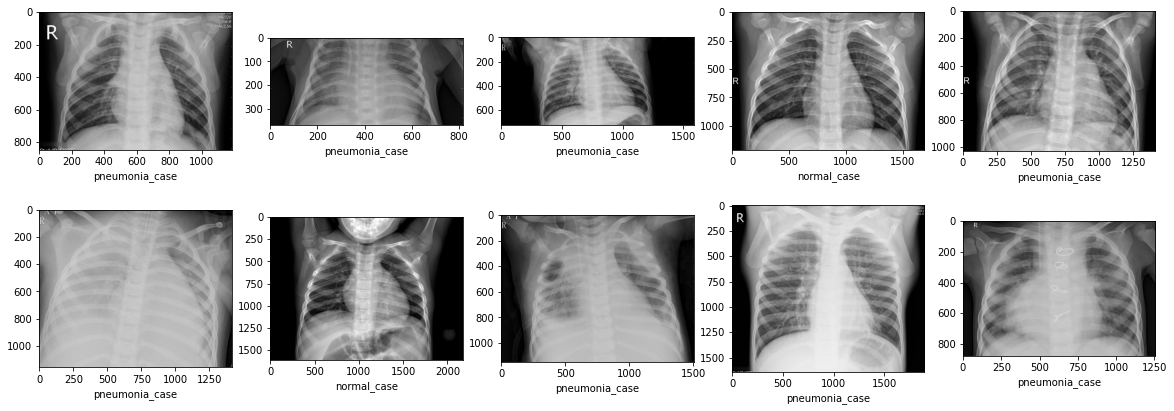

In [ ]:
plt.figure(figsize=(20,7))

for i, data_ in enumerate(data[:10]):
    path, label = data_['img_path'], data_['label']
    plt.subplot(2,5,i+1)
    img = cv2.imread(path)
    plt.imshow(img)
    plt.xlabel(label)

plt.show()

**Creating an augmentation model:**

In [ ]:
aug_model = Sequential()
aug_model.add(ps.RandomFlip())

**Creating image array from image path:**

In [ ]:
images_array = []
images_label = []
IMG_SIZE = (64,64)
for dataa in data:
    category = label2category[dataa['label']]
    label = to_categorical(category, 2)
    img = cv2.imread(dataa['img_path'])
    if category == 0:
       for i in range(2):
         batch = tf.expand_dims(img, 0)
         aug_img = aug_model(batch)
         aug_img = np.array(aug_img[0])
         img = cv2.resize(aug_img, IMG_SIZE)
         img = img / 255
         images_array.append(img)
         images_label.append(label)
    else:
      img = cv2.resize(img, IMG_SIZE)
      img = img / 255
      images_array.append(img)
      images_label.append(label)

In [ ]:
images_array = np.array(images_array)
images_label = np.array(images_label)

print('shape of images array: {}'.format(images_array.shape))
print('shape of images label: {}'.format(images_label.shape))

shape of images array: (7242, 64, 64, 3)
shape of images label: (7242, 2)


**Visualising the number of inputs for each label:**

In [ ]:
def to_labels(labels):
    label_list = []
    for label in labels:
        am = label.argmax()
        label_list.append(category2label[am])

    return Counter(label_list)
img_l_counter = to_labels(images_label)
keys = list(img_l_counter.keys())
values = list(img_l_counter.values())
px.bar(x=keys, y=values, color=keys, width=800, height=400)

**Splitting into training and testing set:**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(images_array, images_label, test_size=0.3, random_state=None)
print('train input shape: {}'.format(x_train.shape))
print('train output shape: {}'.format(y_train.shape))
print('test input shape: {}'.format(x_test.shape))
print('test output shape: {}'.format(y_test.shape))

train input shape: (5069, 64, 64, 3)
train output shape: (5069, 2)
test input shape: (2173, 64, 64, 3)
test output shape: (2173, 2)


**Creating the model:**

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3,3), input_shape=x_train.shape[1:], activation='relu'))
model.add(MaxPooling2D((2,2), strides=(1,1), padding='same'),)

model.add(Conv2D(64, (3,3), activation='relu'),)
model.add(MaxPooling2D((2,2), strides=(1,1), padding='same'),)

model.add(Conv2D(128, (3,3), activation='relu'),)
model.add(MaxPooling2D((2,2), strides=(1,1), padding='same'),)
model.add(Dropout(0.2))

model.add(Conv2D(512, (3,3), activation='relu'),)
model.add(MaxPooling2D((2,2), strides=(1,1), padding='same'),)

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

**Model Summary:**

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 60, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 58, 58, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 58, 58, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 58, 58, 128)      

**Compiling the model:**

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

**Creating the callbacks:**

In [ ]:
callback = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights = True)

**Training the model:**

In [ ]:
EPOCHS = 40
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=EPOCHS, callbacks=[callback])

Epoch 1/40
159/159 [==============================] - 112s 414ms/step - loss: 1.9122 - accuracy: 0.8091 - val_loss: 0.1204 - val_accuracy: 0.9535
Epoch 2/40
159/159 [==============================] - 62s 388ms/step - loss: 0.1471 - accuracy: 0.9469 - val_loss: 0.1892 - val_accuracy: 0.9416
Epoch 3/40
159/159 [==============================] - 62s 388ms/step - loss: 0.1133 - accuracy: 0.9606 - val_loss: 0.1090 - val_accuracy: 0.9609
Epoch 4/40
159/159 [==============================] - 62s 388ms/step - loss: 0.1034 - accuracy: 0.9631 - val_loss: 0.1043 - val_accuracy: 0.9655
Epoch 5/40
159/159 [==============================] - 62s 387ms/step - loss: 0.0750 - accuracy: 0.9758 - val_loss: 0.1161 - val_accuracy: 0.9687
Epoch 6/40
159/159 [==============================] - 62s 387ms/step - loss: 0.0808 - accuracy: 0.9698 - val_loss: 0.1520 - val_accuracy: 0.9521
Epoch 7/40
159/159 [==============================] - 61s 386ms/step - loss: 0.0734 - accuracy: 0.9735 - val_loss: 0.1134 - val_a

**Testing the model:**

In [ ]:
model.evaluate(x_test, y_test)

68/68 [==============================] - 5s 67ms/step - loss: 0.1493 - accuracy: 0.9724


[0.1492607146501541, 0.9723883867263794]

<Figure size 360x288 with 0 Axes>

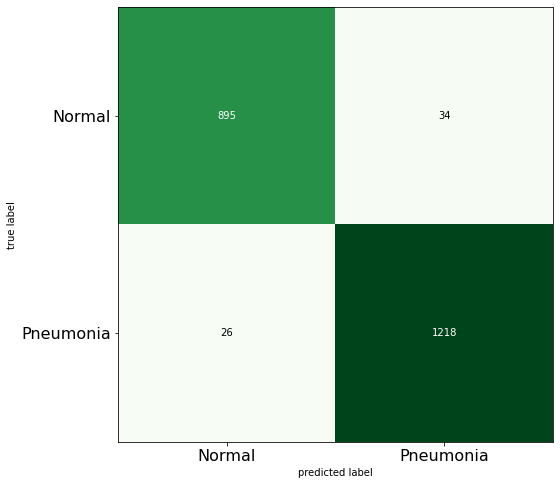

In [ ]:
yhat = model.predict(x_test)
yhat = yhat.argmax(axis=1)
ytrue = y_test.argmax(axis=1)

plt.figure(figsize=(5,4))
plot_confusion_matrix(confusion_matrix(ytrue, yhat), figsize=(12,8), hide_ticks=True, cmap=plt.cm.Greens)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [ ]:
print(classification_report(ytrue, yhat, target_names=['Normal', 'Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.97      0.96      0.97       929
   Pneumonia       0.97      0.98      0.98      1244

    accuracy                           0.97      2173
   macro avg       0.97      0.97      0.97      2173
weighted avg       0.97      0.97      0.97      2173



**Vizualizing training results:**

In [ ]:
_loss, _val_loss = history.history['loss'], history.history['val_loss']
_accuracy, _val_accuracy = history.history['accuracy'], history.history['val_accuracy']
_epochs = range(len(_loss))

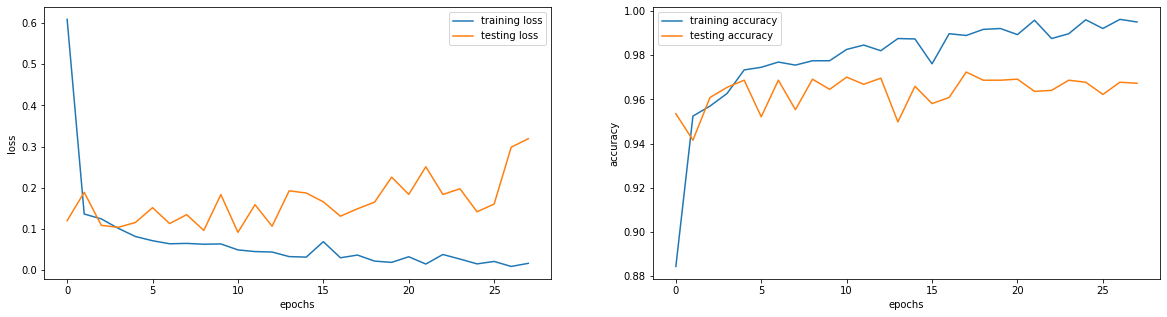

In [ ]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(_epochs, _loss, label='loss')
plt.plot(_epochs, _val_loss, label='val_loss')

plt.xlabel('epochs')
plt.ylabel('loss')

plt.legend(['training loss', 'testing loss'])

plt.subplot(1,2,2)
plt.plot(_epochs, _accuracy, label='accuracy')
plt.plot(_epochs, _val_accuracy, label='val_accuracy')

plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.legend(['training accuracy', 'testing accuracy'])

plt.show()

**Saving the model:**

In [ ]:
model.save('pediatric_pneumonia_predictor.h5')

**Example**

In [ ]:
from google.colab import files
from keras.preprocessing import image
new=files.upload()
for i in new.keys():
  img_path='/content/'+i
  img = image.load_img(img_path, target_size=(64, 64))
  img_array = image.img_to_array(img)
  img_batch = np.expand_dims(img_array, axis=0)
images=np.vstack([img_batch])
prediction = model.predict(img_batch, batch_size = 32)
if prediction[0][0]==1:
  print("Normal case")
else:
  print("Pneumonia case")

Saving unnamed (1).png to unnamed (1).png


NameError: ignored